### Import Libraries

In [2]:
import pandas as pd
import numpy as np
import time
import datetime
from datetime import datetime
import statsmodels.api as sm
import matplotlib .pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore") # specify to ignore warning messages,

from pmdarima import auto_arima
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

from statsmodels.tsa.stattools import ccovf,ccf,periodogram
from statsmodels.tsa.stattools import adfuller,kpss,coint,bds,q_stat,grangercausalitytests,levinson_durbin
from statsmodels.tools.eval_measures import mse, rmse, meanabs
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose

### Load Data

In [3]:
df = pd.read_csv('2gTraffic_MLI058MG1.csv')
df.head()

,year,week,volume_tch_traffic_erl
0,2018,1,822.786389
1,2018,2,719.342778
2,2018,3,697.771389
3,2018,4,628.986111
4,2018,5,719.001389


In [4]:
df.count()

year                      107
week                      107
volume_tch_traffic_erl    107
dtype: int64

In [5]:
df.tail()

,year,week,volume_tch_traffic_erl
102,2019,50,90.145000
103,2019,51,93.177500
104,2019,52,96.820278
105,2020,1,93.183333
106,2020,2,92.586389


This data contain traffic 2G in one of cell from first week at 2018 until second week at 2020. As this data weekly and need a date from those week so I'll create date index with frequency week then join to the data.

In [6]:
#create index
index = pd.date_range('2018-01-01', periods=107, freq='W')
index

DatetimeIndex(['2018-01-07', '2018-01-14', '2018-01-21', '2018-01-28',
               '2018-02-04', '2018-02-11', '2018-02-18', '2018-02-25',
               '2018-03-04', '2018-03-11',
               ...
               '2019-11-17', '2019-11-24', '2019-12-01', '2019-12-08',
               '2019-12-15', '2019-12-22', '2019-12-29', '2020-01-05',
               '2020-01-12', '2020-01-19'],
              dtype='datetime64[ns]', length=107, freq='W-SUN')

In [7]:
#set index df with above index
df.set_index(index, inplace=True)
df.index

DatetimeIndex(['2018-01-07', '2018-01-14', '2018-01-21', '2018-01-28',
               '2018-02-04', '2018-02-11', '2018-02-18', '2018-02-25',
               '2018-03-04', '2018-03-11',
               ...
               '2019-11-17', '2019-11-24', '2019-12-01', '2019-12-08',
               '2019-12-15', '2019-12-22', '2019-12-29', '2020-01-05',
               '2020-01-12', '2020-01-19'],
              dtype='datetime64[ns]', length=107, freq='W-SUN')

In [8]:
#add name 'Date' to index
df.index.name='Date'

In [9]:
df.head()

,year,week,volume_tch_traffic_erl
Date,,,
2018-01-07,2018,1,822.786389
2018-01-14,2018,2,719.342778
2018-01-21,2018,3,697.771389
2018-01-28,2018,4,628.986111
2018-02-04,2018,5,719.001389


### Analysis

In [10]:
#summary statistic
df.describe()

,year,week,volume_tch_traffic_erl
count,107.000000,107.000000,107.000000
mean,2018.523364,26.280374,396.881895
std,0.538092,15.471699,272.868705
min,2018.000000,1.000000,28.559722
25%,2018.000000,13.000000,92.086528
50%,2019.000000,26.000000,413.091389
75%,2019.000000,39.500000,614.031944
max,2020.000000,53.000000,949.354444


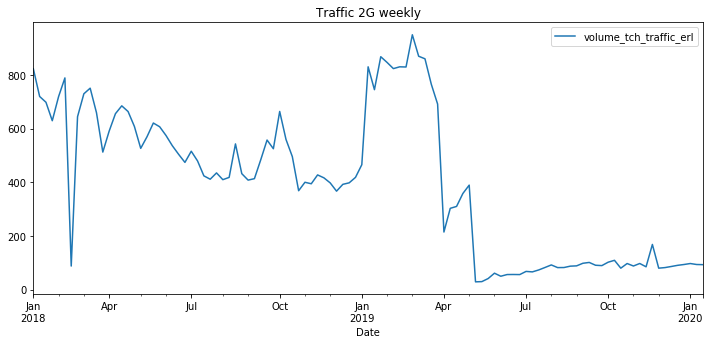

In [11]:
#plot grafik traffic
df['volume_tch_traffic_erl'].plot(figsize=(12,5), legend=True, title='Traffic 2G weekly').autoscale(axis='x', tight=True)

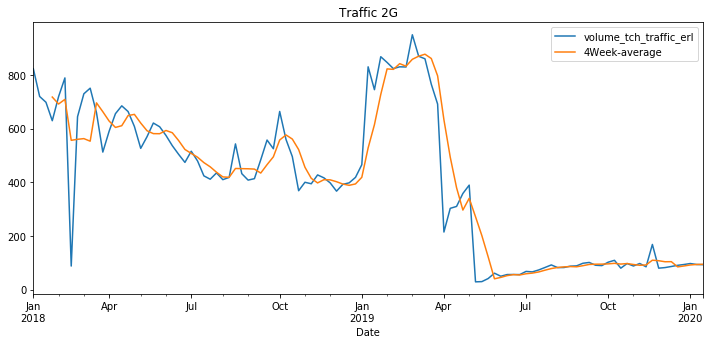

In [12]:
#calculate 4week average
df['4Week-average'] = df['volume_tch_traffic_erl'].rolling(window=4).mean()
df[['volume_tch_traffic_erl', '4Week-average']].plot(figsize=(12,5), title ='Traffic 2G').autoscale(axis='x', tight=True)

From grafic above, it's can be seen that traffic goes down from around first week at april until at the end of the period. However, there are some insignificant increasing.

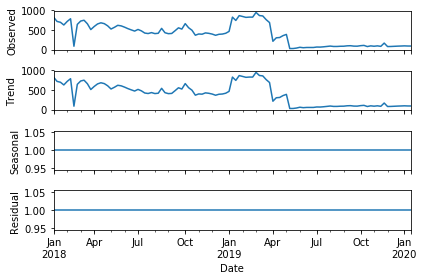

In [13]:
#Lets plot decompose to see a trend, seasonal and residual of data
result = seasonal_decompose(df['volume_tch_traffic_erl'], model='multiplicative', freq=1)
result.plot();

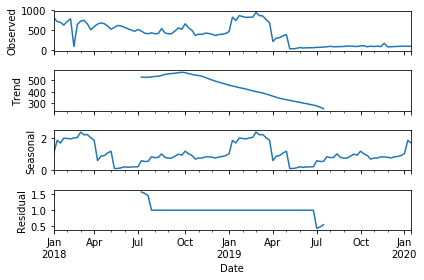

In [14]:
#Lets plot decompose to see a trend, seasonal and residual of data
result = seasonal_decompose(df['volume_tch_traffic_erl'], model='multiplicative')
result.plot();

From grafik above, no seasonal data if frequency = 1, its mean no seasonal pattren in week period.

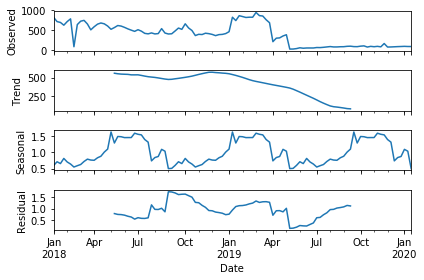

In [30]:
#Lets plot decompose to see a trend, seasonal and residual of data
result = seasonal_decompose(df['volume_tch_traffic_erl'], model='multiplicative', freq=36)
result.plot();

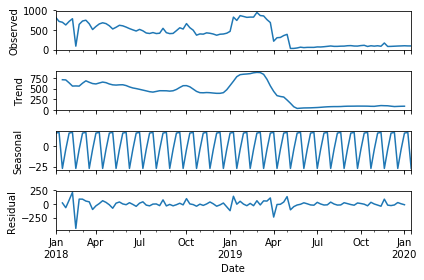

In [17]:
#Lets plot decompose to see a trend, seasonal and residual of data
result = seasonal_decompose(df['volume_tch_traffic_erl'], model='add', freq=4)
result.plot();

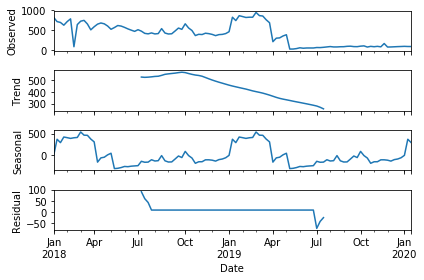

In [18]:
#Lets plot decompose to see a trend, seasonal and residual of data
result = seasonal_decompose(df['volume_tch_traffic_erl'], model='add')
result.plot();

### Holt-Winter

Make a model using Holt-Winter method.

#### Split data into data train n data test

Split data into train and test with proportion train 80% and test 20%.

In [19]:
train = df.iloc[:89]
test = df.iloc[89:]

In [20]:
#show data train
train

,year,week,volume_tch_traffic_erl,4Week-average
Date,,,,
2018-01-07,2018,1,822.786389,NaN
2018-01-14,2018,2,719.342778,NaN
2018-01-21,2018,3,697.771389,NaN
2018-01-28,2018,4,628.986111,717.221667
2018-02-04,2018,5,719.001389,691.275417
...,...,...,...,...
2019-08-18,2019,32,81.901667,84.307222
2019-08-25,2019,33,86.994167,85.533194
2019-09-01,2019,34,88.107778,84.663472


In [21]:
#show data test
test

,year,week,volume_tch_traffic_erl,4Week-average
Date,,,,
2019-09-22,2019,37,90.442500,94.302847
2019-09-29,2019,38,89.076111,94.544931
2019-10-06,2019,39,101.799722,95.545903
2019-10-13,2019,40,108.790556,97.527222
2019-10-20,2019,41,79.504167,94.792639
2019-10-27,2019,42,96.865278,96.739931
2019-11-03,2019,43,87.605000,93.191250
2019-11-10,2019,44,96.964167,90.234653
2019-11-17,2019,45,84.628333,91.515694


In [22]:
#create model exponential smoothing
modelExpo=ExponentialSmoothing(train['volume_tch_traffic_erl'], trend='add', seasonal='mul', seasonal_periods=4).fit()

In [23]:
#make prediction
test_predictions=modelExpo.forecast(len(test))

In [24]:
#show result of prediction
test_predictions

2019-09-22     98.723146
2019-09-29     90.263133
2019-10-06     95.282995
2019-10-13    100.874960
2019-10-20     98.723144
2019-10-27     90.263131
2019-11-03     95.282994
2019-11-10    100.874958
2019-11-17     98.723143
2019-11-24     90.263130
2019-12-01     95.282992
2019-12-08    100.874957
2019-12-15     98.723142
2019-12-22     90.263129
2019-12-29     95.282991
2020-01-05    100.874956
2020-01-12     98.723140
2020-01-19     90.263128
Freq: W-SUN, dtype: float64

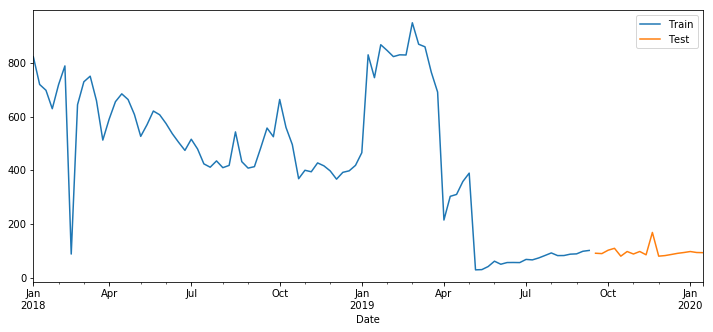

In [25]:
#plot train and test
train['volume_tch_traffic_erl'].plot(legend=True, label='Train')
test['volume_tch_traffic_erl'].plot(legend=True, label='Test', figsize=(12,5))

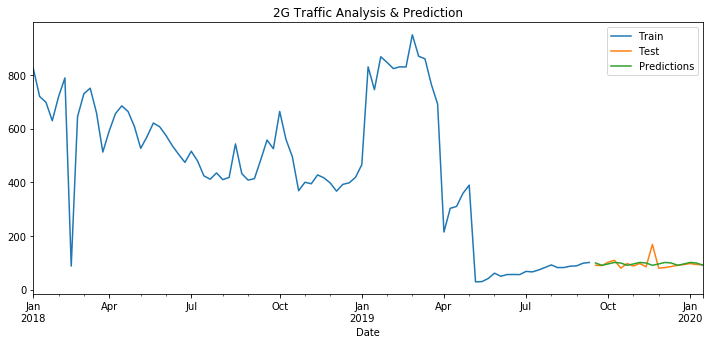

In [27]:
#plot the prediction and actual data
train['volume_tch_traffic_erl'].plot(legend=True, label='Train')
test['volume_tch_traffic_erl'].plot(legend=True, label='Test', figsize=(12,5), title = '2G Traffic Analysis & Prediction')
test_predictions.plot(legend=True, label='Predictions')

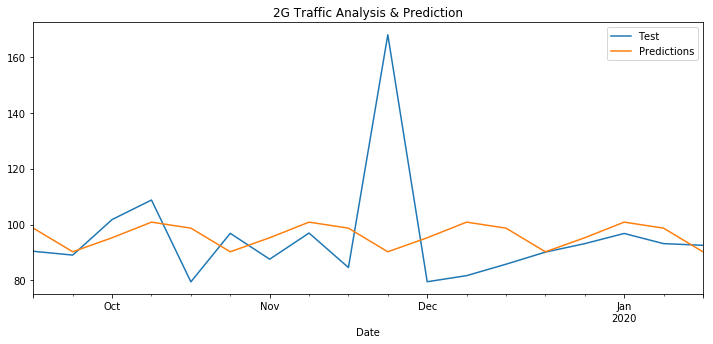

In [28]:
#plot prediction and actual data(test data)
test['volume_tch_traffic_erl'].plot(legend=True, label='Test', figsize=(12,5), title = '2G Traffic Analysis & Prediction')
test_predictions.plot(legend=True, label='Predictions')

In [81]:
# model evaluation with mean absolute error
mean_absolute_error(test['volume_tch_traffic_erl'], test_predictions)

11.945517485910358

In [83]:
#model evaluation with mean squared error
mean_squared_error(test['volume_tch_traffic_erl'], test_predictions)

429.5346502577789

In [84]:
#model evaluation with RMSE
np.sqrt(mean_squared_error(test['volume_tch_traffic_erl'], test_predictions))

20.725217737282733

In [29]:
#calculate mean square error
error = mean_squared_error(test['volume_tch_traffic_erl'], test_predictions)
print(f'Holt Winter MSE Error: {error}')

#calculate rmse
rmse = np.sqrt(mean_squared_error(test['volume_tch_traffic_erl'], test_predictions))
print(f'Holt Winter RMSE: {rmse}')

Holt Winter MSE Error: 429.5346502577789
Holt Winter RMSE: 20.725217737282733


In [82]:
#check summary statistic from data test
test['volume_tch_traffic_erl'].describe()

count     18.000000
mean      95.366435
std       19.640287
min       79.504167
25%       86.261875
50%       91.514444
75%       96.854028
max      167.931389
Name: volume_tch_traffic_erl, dtype: float64

The RMSE is 20.72 which is not too bad if compared it with the standard deviation of data test (19.64). So, this model not too bad I think. However, lets try to make model with ARIMA.

### ARIMA

#### Test Stationary
Use the Dickey-Fuller test to check stationary data.

In [86]:
#Check stationary data with Dickey Fuller
test_stat=adfuller(df['volume_tch_traffic_erl'],autolag='AIC')
test_stat

print('Augmented Dickey-Fuller Test on Traffic 2G data')

testout = pd.Series(test_stat[0:4],index=['ADF test statistic','p-value','# lags used','# observations'])

for key,val in test_stat[4].items():
    testout[f'critical value ({key})']=val
print(testout)

Augmented Dickey-Fuller Test on Traffic 2G data
ADF test statistic       -2.493897
p-value                   0.116966
# lags used               0.000000
# observations          106.000000
critical value (1%)      -3.493602
critical value (5%)      -2.889217
critical value (10%)     -2.581533
dtype: float64


From result above, p-value is 0.117 its mean week evidence against null hypothesis or fail to reject the null hypothesis and decide the data is **non-stationary**. 

It is important to make the data stationary, one of the way to make stationary is differencing. To check how much the differencing that needed, it can be seen from its autocorrelation(ACF)

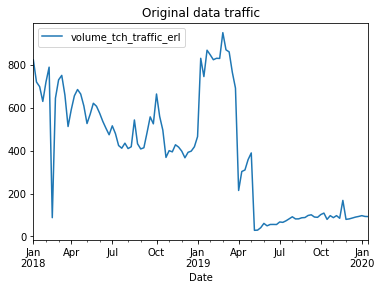

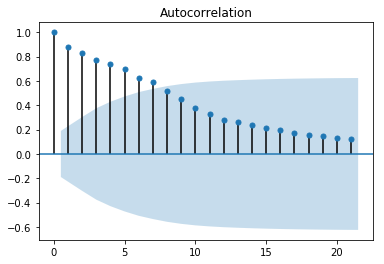

In [88]:
#plot original data and its autocorrelation
df['volume_tch_traffic_erl'].plot(legend=True, title='Original data traffic')
#plt.subplot(122)
plot_acf(df['volume_tch_traffic_erl'])
plt.show()

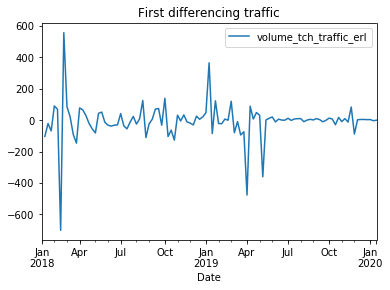

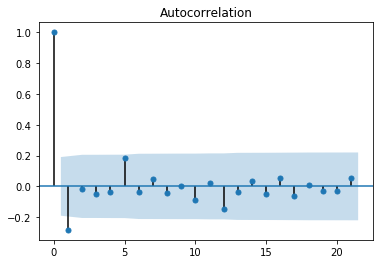

In [91]:
#plot first differencing and its autocorrelation
#calculate first differencing
diff1=df['volume_tch_traffic_erl'].diff()

diff1.plot(legend=True, title='First differencing traffic')
#plt.subplot(122)
plot_acf(diff1.dropna())
plt.show()

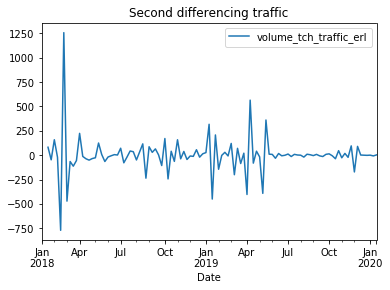

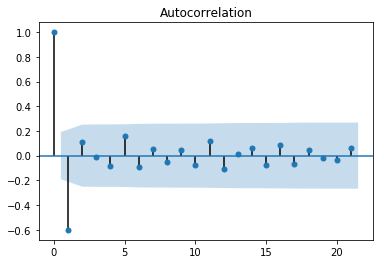

In [92]:
#plot second differencing and its autocorrelation
#calculate first differencing
diff2=diff1.diff()

diff2.plot(legend=True, title='Second differencing traffic')
#plt.subplot(122)
plot_acf(diff2.dropna())
plt.show()

From plot differencing and autocorrelation above, the time series reaches the stationary with first order differencing. At the autocorrelation plot for the fist differencing the lag goes to negative zone quickly, so in this case i choose differencing 1. However, lets check augmented Dickey Fuller test at the first difference, whether data reach stationary on the first difference or not.

Next we define the value of p, where p is term of AutoRegression (AR). The AR term can difine by inspecting the Partial AutoCorrelation (PACF) plot.


#### Dickey Fuller Test on the first difference

In [109]:
test_stat=adfuller(diff1.dropna(), autolag='AIC')
print('Augmented Dickey-Fuller Test on the first difference 2G Traffic')

testout=pd.Series(test_stat[0:4], index=['ADF test statistic','p-value','# lags used','# observations'])

for key, val in test_stat[4].items():
    testout[f'critical value ({key})']=val
print(testout)
#adf_test(df2['d1'],'Real Manufacturing and Trade Inventories')

Augmented Dickey-Fuller Test on the first difference 2G Traffic
ADF test statistic     -1.361179e+01
p-value                 1.867167e-25
# lags used             0.000000e+00
# observations          1.050000e+02
critical value (1%)    -3.494220e+00
critical value (5%)    -2.889485e+00
critical value (10%)   -2.581676e+00
dtype: float64


From result above, p-value is 1.867167e-25 its mean data reach stationary on the first difference.

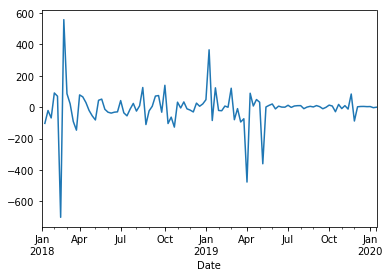

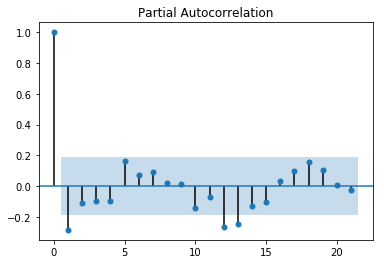

In [95]:
#plot the time series first differencing with Partial AutoCorrelation
#plot first differencing
diff1.plot()

#plot partial autocorrelation
plot_pacf(diff1.dropna());

From above diagram,the PACF lag 1 is well significant as above the significant line but at lag 12 and 13 the lag above the significant line so, in this case the value of p is none because no cut-off in PACF

Next we define the value of q where q is the term of MA, ACF plot can be used to define number of MA term. An MA term is technically error of the lagged forecast. To define q, it can be seen from the plot its autocorrelation in first differencing data and From result above, in lag 1 is well as above significant line. This value will be used to define q, so in this case q = 1. 

Now, we already have the value of d,p and q which is 1,0 and 1 respectively. Then, we will make ARIMA model.

In [31]:
#build ARIMA model with all data
model = ARIMA(df['volume_tch_traffic_erl'], order=(0,1,1))

#fit the model
result=model.fit()

#print the summary model
print(result.summary())

                                ARIMA Model Results                                 
Dep. Variable:     D.volume_tch_traffic_erl   No. Observations:                  106
Model:                       ARIMA(0, 1, 1)   Log Likelihood                -654.280
Method:                             css-mle   S.D. of innovations            115.924
Date:                      Tue, 28 Jan 2020   AIC                           1314.559
Time:                              14:46:42   BIC                           1322.549
Sample:                          01-14-2018   HQIC                          1317.798
                               - 01-19-2020                                         
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                             -6.5753      7.476     -0.880      0.381     -21.227       8.077
ma.L1.D.volume_tch_traf

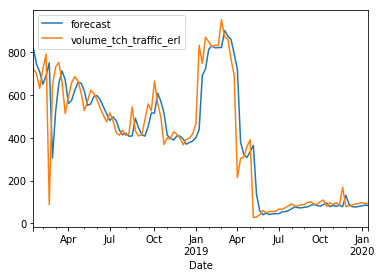

In [32]:
# Plot actual vs forecast
result.plot_predict(dynamic=False) #dynamic false means the in-sample lagged values are used for prediction. 
plt.show()

Now, lets train and test ARIMA(0,1,1) and evaluate model.

In [33]:
#build model ARIMA on data train
model = ARIMA(train['volume_tch_traffic_erl'], order=(0,1,1))

#fit model
result = model.fit()

#print summary model
print(result.summary())

                                ARIMA Model Results                                 
Dep. Variable:     D.volume_tch_traffic_erl   No. Observations:                   88
Model:                       ARIMA(0, 1, 1)   Log Likelihood                -550.947
Method:                             css-mle   S.D. of innovations            126.613
Date:                      Tue, 28 Jan 2020   AIC                           1107.894
Time:                              14:47:04   BIC                           1115.326
Sample:                          01-14-2018   HQIC                          1110.888
                               - 09-15-2019                                         
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                             -7.8746      9.002     -0.875      0.384     -25.518       9.769
ma.L1.D.volume_tch_traf

In [34]:
#make prediction
start = len(train)
end = len(train)+len(test)-1
predictions = result.predict(start=start, end=end, dynamic=False, typ='levels').rename('ARIMA(0,1,1) Predictions')

In [35]:
# Compare predictions to expected values
for i in range(len(predictions)):
    print(f"predicted={predictions[i]:<11.10}, expected={test['volume_tch_traffic_erl'][i]}")

predicted=86.75307175, expected=90.4425
predicted=78.87844524, expected=89.07611111
predicted=71.00381872, expected=101.7997222
predicted=63.1291922 , expected=108.7905556
predicted=55.25456568, expected=79.50416667
predicted=47.37993916, expected=96.86527778
predicted=39.50531264, expected=87.605
predicted=31.63068612, expected=96.96416667
predicted=23.7560596 , expected=84.62833333
predicted=15.88143309, expected=167.9313889
predicted=8.006806567, expected=79.54
predicted=0.1321800488, expected=81.72194444
predicted=-7.74244647, expected=85.81416667
predicted=-15.61707299, expected=90.145
predicted=-23.49169951, expected=93.1775
predicted=-31.36632603, expected=96.82027778
predicted=-39.24095254, expected=93.18333333
predicted=-47.11557906, expected=92.58638889


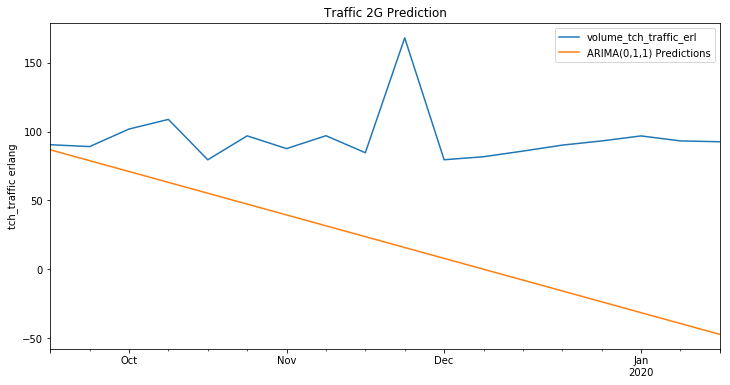

In [36]:
#plot predictions against real data
title ='Traffic 2G Prediction'
ylabel = 'tch_traffic erlang'
xlabel=''

ax= test['volume_tch_traffic_erl'].plot(legend=True, figsize=(12,6), title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x', tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

### Evaluate model

In [115]:
#calculate MSE 
error = mean_squared_error(test['volume_tch_traffic_erl'], predictions)
print(f'ARIMA(1,1,1) MSE Error: {error:11.10}')

ARIMA(1,1,1) MSE Error: 7865.792312


In [117]:
#calculate RMSE
error = np.sqrt(mean_squared_error(test['volume_tch_traffic_erl'], predictions))
print(f'ARIMA(1,1,1) RMSE Error:{error:11.10}')

ARIMA(1,1,1) RMSE Error:88.68930213


Model above not qood enaught. And lets try auto arima

#### Auto Arima

In [126]:
auto_arima(df['volume_tch_traffic_erl'], seasonal=False, m=12).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  107
Model:               SARIMAX(0, 1, 1)   Log Likelihood                -654.250
Date:                Sat, 25 Jan 2020   AIC                           1314.501
Time:                        21:44:08   BIC                           1322.491
Sample:                             0   HQIC                          1317.739
                                - 107                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -6.4675      9.182     -0.704      0.481     -24.465      11.530
ma.L1         -0.3402      0.058     -5.846      0.000      -0.454      -0.226
sigma2      1.347e+04    849.690     15.847      0.000    1.18e+04    1.51e+04
===================================================================================
Ljung-Box (Q):                       29.52   Jarque-Bera (JB):               843.58
Prob(Q):                              0.89   Prob(JB):                         0.00
Heteroskedasticity (H):               0.02   Skew:                            -2.06
Prob(H) (two-sided):                  0.00   Kurtosis:                        16.19
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

##### Result of auto arima also same order (0,1,1)

In [127]:
#try auto arima with seasonal true
auto_arima(df['volume_tch_traffic_erl'], seasonal=True, m=12).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  107
Model:             SARIMAX(0, 1, 1)x(1, 0, 2, 12)   Log Likelihood                -648.241
Date:                            Sat, 25 Jan 2020   AIC                           1308.483
Time:                                    21:44:54   BIC                           1324.463
Sample:                                         0   HQIC                          1314.960
                                            - 107                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.6122      3.067     -0.526      0.599      -7.623       4.398
ma.L1         -0.4157      0.067     -6.229      0.000      -0.547      -0.285
ar.S.L12       0.7522      0.360      2.090      0.037       0.047       1.458
ma.S.L12      -1.1788      0.453     -2.600      0.009      -2.067      -0.290
ma.S.L24       0.5046      0.162      3.112      0.002       0.187       0.822
sigma2      1.129e+04   1361.124      8.294      0.000    8620.779     1.4e+04
===================================================================================
Ljung-Box (Q):                       31.05   Jarque-Bera (JB):               417.42
Prob(Q):                              0.84   Prob(JB):                         0.00
Heteroskedasticity (H):               0.13   Skew:                            -1.44
Prob(H) (two-sided):                  0.00   Kurtosis:                        12.29
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#### SARIMAX(0,1,1)x(1,0,2,12)

In [137]:
SARIMA_model2 = SARIMAX(train['volume_tch_traffic_erl'], order=(0,1,1), seasonal_order=(1,0,2,12))
result2 = SARIMA_model2.fit()
result2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:             volume_tch_traffic_erl   No. Observations:                   89
Model:             SARIMAX(0, 1, 1)x(1, 0, 2, 12)   Log Likelihood                -546.312
Date:                            Sat, 25 Jan 2020   AIC                           1102.624
Time:                                    22:11:39   BIC                           1115.010
Sample:                                01-07-2018   HQIC                          1107.614
                                     - 09-15-2019                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3975      0.078     -5.119      0.000      -0.550      -0.245
ar.S.L12       0.8118      0.417      1.947      0.051      -0.005       1.629
ma.S.L12      -1.2313      0.561     -2.194      0.028      -2.331      -0.131
ma.S.L24       0.5135      0.185      2.771      0.006       0.150       0.877
sigma2      1.329e+04   2202.712      6.035      0.000    8975.439    1.76e+04
===================================================================================
Ljung-Box (Q):                       24.66   Jarque-Bera (JB):               251.42
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               0.52   Skew:                            -1.32
Prob(H) (two-sided):                  0.08   Kurtosis:                        10.85
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [146]:
# Obtain predicted values
start=len(train)
end=len(train)+len(test)-1
predictions2 = result2.predict(start=start, end=end, dynamic=False, typ='levels').rename('SARIMA(0,1,1)x(1,0,2,12) Predictions')

In [147]:
predictions2

2019-09-22    152.366665
2019-09-29     71.877659
2019-10-06    133.483545
2019-10-13    150.794073
2019-10-20    125.603463
2019-10-27    108.944815
2019-11-03    100.411189
2019-11-10    130.713599
2019-11-17    140.215586
2019-11-24    129.839186
2019-12-01    132.236305
2019-12-08    103.026353
2019-12-15     61.138274
2019-12-22     68.092506
2019-12-29     81.459304
2020-01-05     90.718381
2020-01-12     95.001868
2020-01-19     22.625639
Freq: W-SUN, Name: SARIMA(0,1,1)x(1,0,2,12) Predictions, dtype: float64

In [148]:
# Compare predictions to expected values
for i in range(len(predictions2)):
    print(f"predicted={predictions2[i]:<11.10}, expected={test['volume_tch_traffic_erl'][i]}")

predicted=152.3666652, expected=90.4425
predicted=71.87765867, expected=89.07611111
predicted=133.4835454, expected=101.7997222
predicted=150.7940733, expected=108.7905556
predicted=125.6034633, expected=79.50416667
predicted=108.9448151, expected=96.86527778
predicted=100.4111889, expected=87.605
predicted=130.7135993, expected=96.96416667
predicted=140.2155856, expected=84.62833333
predicted=129.8391856, expected=167.9313889
predicted=132.2363049, expected=79.54
predicted=103.0263526, expected=81.72194444
predicted=61.13827433, expected=85.81416667
predicted=68.09250622, expected=90.145
predicted=81.45930424, expected=93.1775
predicted=90.71838124, expected=96.82027778
predicted=95.00186798, expected=93.18333333
predicted=22.62563897, expected=92.58638889


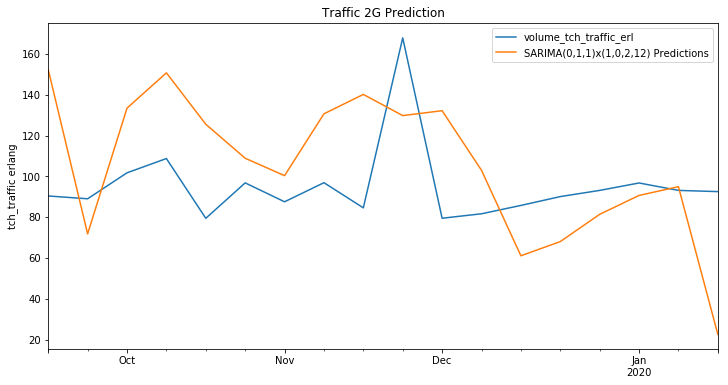

In [149]:
#plot predictions against real data
title ='Traffic 2G Prediction'
ylabel = 'tch_traffic erlang'
xlabel=''

ax= test['volume_tch_traffic_erl'].plot(legend=True, figsize=(12,6), title=title)
predictions2.plot(legend=True)
ax.autoscale(axis='x', tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

#### Evaluate Model SARIMAX(0,1,1)x(1,0,2,12)

In [155]:
#calculate mean square error
error = mean_squared_error(test['volume_tch_traffic_erl'], predictions2)
print(f'SARIMAX(0,1,1)x(1,0,2,12) MSE Error: {error}')

#calculate rmse
rmse = np.sqrt(mean_squared_error(test['volume_tch_traffic_erl'], predictions2))
print(f'SARIMAX(0,1,1)x(1,0,2,12) RMSE: {rmse}')


SARIMAX(0,1,1)x(1,0,2,12) MSE Error: 1356.2191178155217
SARIMAX(0,1,1)x(1,0,2,12) RMSE: 36.826880370396864


In [156]:
test['volume_tch_traffic_erl'].describe()

count     18.000000
mean      95.366435
std       19.640287
min       79.504167
25%       86.261875
50%       91.514444
75%       96.854028
max      167.931389
Name: volume_tch_traffic_erl, dtype: float64